In [1]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

In [2]:
def ends(df, x=5):
    return df.head(x).append(df.tail(x))

# Load original data

In [3]:
#file_path = ".\data\train.csv"
file_path = os.path.join('data', 'train.csv')


# Option 1 for reading a sample of the file
n_total_rows = 2437645
prc_rows_to_read = 10
n_rows_to_read = int(prc_rows_to_read/100*n_total_rows)
n_rows_to_skip = n_total_rows - n_rows_to_read

random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change
list_of_rows_to_skip = random.sample(
    range(1, n_total_rows-1), # this is a range from the first row after the header, to the last row on the file
    n_rows_to_skip # this is the number of rows we want to sample, i.e, to skip
)


# Option 2 for reading a sample of the file
# sample 20% of the rows
p = 0.8

try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')


# Transform data to analysis

In [4]:
remane_columns_dict = {'VehicleSearchedIndicator': 'search', 
                       'ContrabandIndicator': 'target', 
                       'Department Name': 'departm',
                       'InterventionDateTime': 'date',
                       'InterventionLocationName': 'local',
                       'InterventionReasonCode': 'reason',
                       'ReportingOfficerIdentificationID': 'officerID',
                       'ResidentIndicator': 'state_res',
                       'SearchAuthorizationCode': 'search_reason',
                       'StatuteReason': 'stop_reason',
                       'SubjectAge': 'age',
                       'SubjectEthnicityCode': 'ethnic',
                       'SubjectRaceCode': 'race',
                       'SubjectSexCode': 'sex',
                       'TownResidentIndicator': 'town_res'
                      }

In [5]:
def simple_clean(doc, regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")] ):
    
    # Make sure it is a string!
    doc = str(doc)
    
    # remove or replace characters
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    # lowercase
    doc = doc.lower()
    # Trim
    doc = doc.strip()
    # tokenize
    #words = tokenizer.tokenize(doc)
    # remove punctuation
    #words = list(filter(lambda x: x not in string.punctuation, words))
    # stem
    #stems = list(map(stemmer.stem, words))
    #new_doc = " ".join(stems)
    new_doc = doc
    return new_doc

In [6]:
simple_clean("    North@ /* -  America . ?  )  ; !     north- america   ")

'north america north america'

In [7]:
def data_transformer(df_original: pd.DataFrame, columns_dict: dict) -> pd.DataFrame:
    """Transforms the original DataFrame to make it suited for data analysis.
    
    Args:
        df_original (pd.DataFrame):  Original DataFrame, as imported by pd.read_csv().
        columns_dict (dict): Correspondence between old a new column names.
        
    Returns:
        df (pd.DataFrame): Transformed DataFrame, ready for data analysis.
        
    TODO:
        * to do list
        
    """
    
    df = df_original.copy()
    
    # change column names
    df = df.rename(columns = columns_dict)
    
    # convert date to pd.datetime
    df.date = pd.to_datetime(df.date)
    
    # Clean strings from special characters and multiple spaces
    df.local = df.local.apply(simple_clean)
    df.departm = df.departm.apply(simple_clean)
    
    # convert Intervention DateTime to index of the DataFrame
    #df = df.set_index('date').sort_index()
    
   
    return df

df = data_transformer(df_original, remane_columns_dict)

In [8]:
dfs = df[df.search==True].reset_index()
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61452 entries, 0 to 61451
Data columns (total 16 columns):
index            61452 non-null int64
search           61452 non-null bool
target           61452 non-null bool
departm          61452 non-null object
date             61452 non-null datetime64[ns]
local            61452 non-null object
reason           61452 non-null object
officerID        61452 non-null object
state_res        61452 non-null bool
search_reason    61443 non-null object
stop_reason      61445 non-null object
age              61452 non-null float64
ethnic           61452 non-null object
race             61452 non-null object
sex              61452 non-null object
town_res         61452 non-null bool
dtypes: bool(4), datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 5.9+ MB


In [9]:
target_global_mean = dfs.target.mean()
target_global_mean

0.33321942328972204

In [10]:
dfs.groupby('sex')['target'].mean()

sex
F    0.322227
M    0.335676
Name: target, dtype: float64

In [11]:
dfs.groupby('sex').filter(lambda x: x.target.mean() > 0.33)

,index,search,target,departm,date,local,reason,officerID,state_res,search_reason,stop_reason,age,ethnic,race,sex,town_res
0,121,True,True,milford,2013-10-01 01:50:00,milford,E,2325,True,I,Defective Lights,30.0,N,W,M,True
1,167,True,False,state police,2013-10-01 05:30:00,tolland,V,1000002715,False,C,Other,19.0,N,B,M,False
2,175,True,False,greenwich,2013-10-01 05:47:00,riverside,V,110993,False,N,Speed Related,34.0,M,B,M,False
4,324,True,True,milford,2013-10-01 09:04:00,milford,V,2459,True,N,Speed Related,59.0,N,W,M,False
6,578,True,False,naugatuck,2013-10-01 12:40:00,naugatuck,V,PL22,True,O,Display of Plates,29.0,N,B,M,False
7,579,True,True,state police,2013-10-01 12:41:00,bridgeport,V,1000001904,True,O,Registration,20.0,N,B,M,True
8,586,True,False,state police,2013-10-01 12:45:00,montville,I,1000002546,True,C,Suspended License,23.0,M,W,M,False
9,667,True,False,norwalk,2013-10-01 14:15:00,norwalk,V,100000243,True,N,Moving Violation,54.0,N,W,M,True
10,768,True,False,danbury,2013-10-01 16:51:00,danbury,V,1898,True,I,Other,42.0,H,W,M,False
11,783,True,False,plainville,2013-10-01 17:02:00,plainville,E,PH4976,True,C,Stop Sign,60.0,N,W,M,False


In [12]:
dfs.shape[0]/df.local.nunique()

46.66059225512529

### Police Department Name

In [13]:
df_aux = dfs.groupby('departm').target.count().sort_values(ascending=False)
print(df_aux.head())
print(df_aux.tail())

departm
state police     4381
new haven        4020
wallingford      2188
waterbury        1997
west hartford    1762
Name: target, dtype: int64
departm
middlebury                  3
mta stamford                2
met dist water authority    1
ecsu                        1
mta                         1
Name: target, dtype: int64


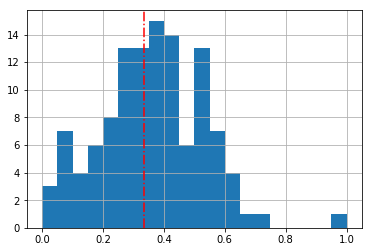

In [14]:
dfs.groupby('departm').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

In [15]:
dfs_by_departm = dfs.groupby('departm').target.agg(['mean','count', 'sum']).sort_values('mean')
dfs_by_departm.head()

,mean,count,sum
departm,,,
middlebury,0.000000,3,0.0
ecsu,0.000000,1,0.0
mta,0.000000,1,0.0
plainfield,0.051643,213,11.0
redding,0.057971,69,4.0


In [16]:
dfs_by_departm['binom_test_p'] = dfs_by_departm.apply(lambda x: binom_test(x['sum'], x['count'], p=target_global_mean), axis=1)

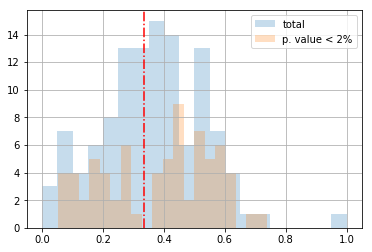

In [17]:
dfs.groupby('departm').target.mean().hist(bins=20, alpha=0.25, label='total')
dfs_by_departm.loc[dfs_by_departm.binom_test_p < 0.02, 'mean'].hist(bins=20, alpha=0.25, label='p. value < 2%')
plt.axvline(x=target_global_mean, color='r', linestyle='-.')
plt.legend();

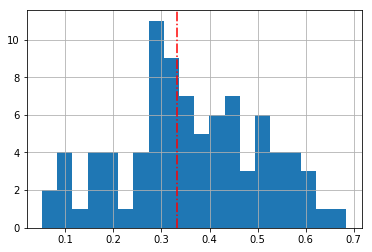

In [18]:
(dfs.groupby('departm')
    .filter(lambda x: x.shape[0]>100)
    .groupby('departm')
    .target.mean()
).hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

### Search Location

In [19]:
dfs_by_local = dfs.groupby('local').target.agg(['mean','count'])

#average_number_of_searches = dfs_by_local['count'].mean()
average_number_of_searches = dfs.shape[0]/df.local.nunique()

dfs_by_local['weight'] = dfs_by_local['count']/average_number_of_searches
#dfs_by_local['count'] = dfs_by_local['count']/total_stops
#dfs_by_local['mean'] = dfs_by_local['mean']*dfs_by_local['count'] 

dfs_by_local['weight_mean'] = dfs_by_local['mean']*dfs_by_local['weight']*100

dfs_by_local.head()

,mean,count,weight,weight_mean
local,,,,
106,0.25,8,0.171451,4.286272
419,0.00,1,0.021431,0.000000
`,1.00,2,0.042863,4.286272
albert st,0.00,1,0.021431,0.000000
andover,0.20,20,0.428627,8.572544


In [20]:
dfs_by_local['weight_mean'].describe()

count     261.000000
mean      168.141755
std       332.569585
min         0.000000
25%         2.143136
50%        27.860769
75%       162.878344
max      2511.755517
Name: weight_mean, dtype: float64

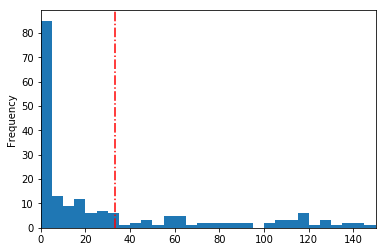

In [21]:
dfs_by_local['weight_mean'].plot.hist(xlim=(0,150), bins=range(0,200,5))
plt.axvline(x=target_global_mean*100, color='r', linestyle='-.');

No handles with labels found to put in legend.


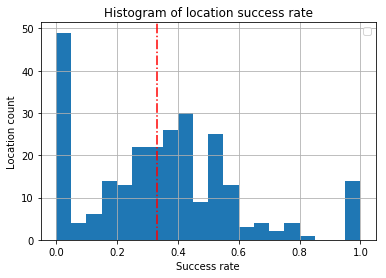

In [22]:
dfs.groupby('local').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.')

#plt.ylim(0, 0.07)
#plt.xlim(15, 80)

#plt.xticks(range(15,80,5))

plt.title('Histogram of location success rate')
plt.xlabel("Success rate")
plt.ylabel("Location count")

plt.legend();

In [23]:
dfs_by_local = dfs.groupby('local').target.agg(['mean','count', 'sum']).sort_values('mean')
dfs_by_local.head()

,mean,count,sum
local,,,
hart,0.0,3,0.0
new harwinton rd,0.0,1,0.0
mashantucket,0.0,1,0.0
central villiage,0.0,1,0.0
southport,0.0,1,0.0


In [24]:
dfs_by_local['binom_test_p'] = dfs_by_local.apply(lambda x: binom_test(x['sum'], x['count'], p=target_global_mean), axis=1)
dfs_by_local[dfs_by_local.binom_test_p < 0.02]

,mean,count,sum,binom_test_p
local,,,,
moosup,0.021505,93,2.0,7.475071e-14
wauregan,0.047619,21,1.0,4.133388e-03
redding,0.057971,69,4.0,5.944812e-08
central village,0.058824,34,2.0,3.426014e-04
derby,0.063291,869,55.0,3.100794e-82
wolcott,0.090909,99,9.0,2.356920e-08
windsor locks,0.139175,194,27.0,9.752896e-10
west haven,0.143863,994,143.0,4.952406e-42
new haven,0.150609,4681,705.0,6.664410e-177


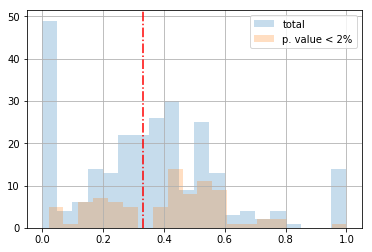

In [25]:
dfs.groupby('local').target.mean().hist(bins=20, alpha=0.25, label='total')
dfs_by_local.loc[dfs_by_local.binom_test_p < 0.02, 'mean'].hist(bins=20, alpha=0.25, label='p. value < 2%')
plt.axvline(x=target_global_mean, color='r', linestyle='-.')
plt.legend();

In [26]:
dfs.groupby('local').target.count().sort_values(ascending=False).describe()

count     261.000000
mean      235.448276
std       491.106359
min         1.000000
25%         4.000000
50%        41.000000
75%       206.000000
max      4681.000000
Name: target, dtype: float64

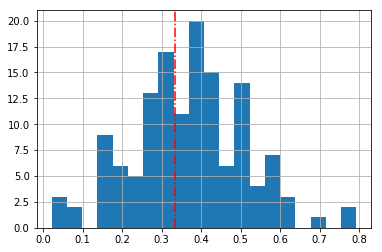

In [27]:
(dfs.groupby('local')
    .filter(lambda x: x.shape[0]>30)
    .groupby('local')
    .target.mean()
).hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

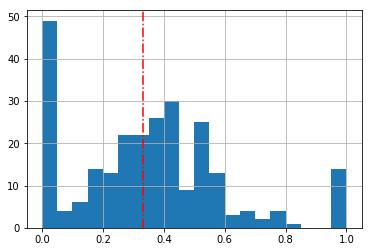

In [28]:
dfs.groupby('local').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

### Search Officer ID

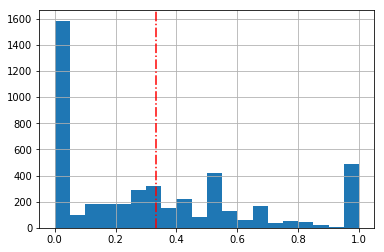

In [29]:
dfs.groupby('officerID').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

In [30]:
dfs.groupby('officerID').target.count().sort_values(ascending=False).describe()

count    4708.000000
mean       13.052676
std        23.477552
min         1.000000
25%         2.000000
50%         5.000000
75%        13.000000
max       420.000000
Name: target, dtype: float64

In [31]:
dfs_by_officerID = dfs.groupby('officerID').target.agg(['mean','count', 'sum']).sort_values('mean')
dfs_by_officerID.head()

,mean,count,sum
officerID,,,
0,0.0,1,0.0
2600,0.0,1,0.0
2602,0.0,2,0.0
2603,0.0,1,0.0
261738198,0.0,1,0.0


In [32]:
dfs_by_officerID['binom_test_p'] = dfs_by_officerID.apply(lambda x: binom_test(x['sum'], x['count'], p=target_global_mean), axis=1)
dfs_by_officerID[dfs_by_officerID.binom_test_p < 0.02]

,mean,count,sum,binom_test_p
officerID,,,,
23750,0.000000,13,0.0,6.792480e-03
30510,0.000000,55,0.0,2.875510e-10
30512,0.000000,17,0.0,1.358085e-03
30495,0.000000,29,0.0,1.125496e-05
30492,0.000000,16,0.0,2.316301e-03
30232,0.000000,17,0.0,1.358085e-03
2098,0.000000,109,0.0,1.344065e-19
203,0.000000,29,0.0,1.125496e-05
610,0.000000,13,0.0,6.792480e-03


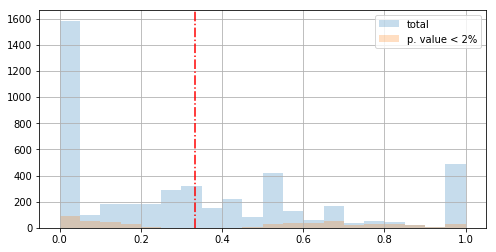

In [33]:
plt.figure(figsize=(8,4))
dfs.groupby('officerID').target.mean().hist(bins=20, alpha=0.25, label='total')
dfs_by_officerID.loc[dfs_by_officerID.binom_test_p < 0.02, 'mean'].hist(bins=20, alpha=0.25, label='p. value < 2%')
plt.axvline(x=target_global_mean, color='r', linestyle='-.')
plt.legend();

### Search Authorization Code

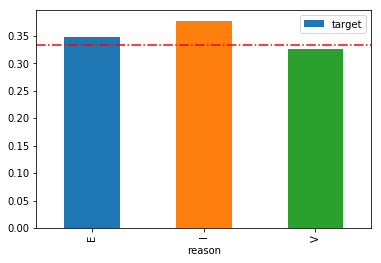

In [34]:
dfs.groupby('reason').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.')
plt.legend();

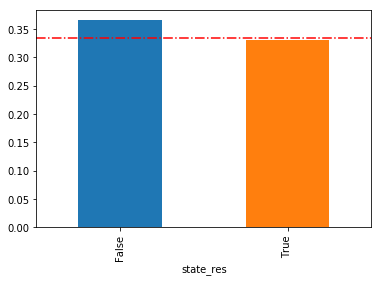

In [35]:
dfs.groupby('state_res').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

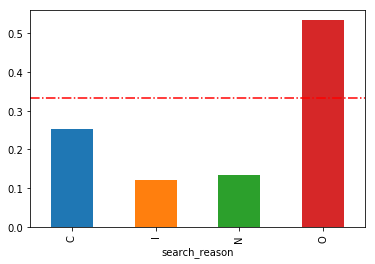

In [36]:
dfs.groupby('search_reason').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

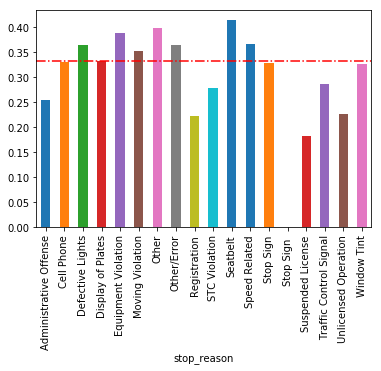

In [37]:
dfs.groupby('stop_reason').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

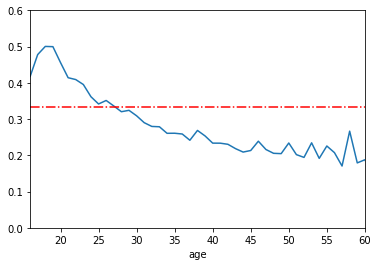

In [38]:
dfs.groupby('age').target.mean().plot()
plt.xlim(16,60)
plt.ylim(0,0.6)
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

In [39]:
dfs.groupby('age').target.count().sum()

61452

In [40]:
bins=list(range(0,80,5))
bins

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

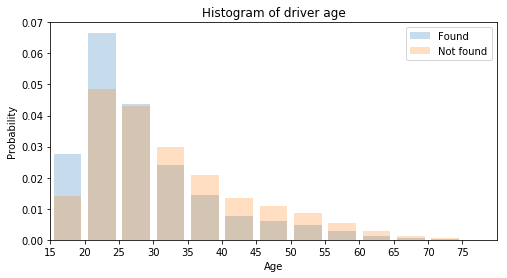

In [41]:
dfs[dfs.target==True].age.plot.hist( bins=range(0,80,5), figsize=(8,4), align='mid', rwidth=0.8, label='Found', density=True, alpha=0.25)
dfs[dfs.target==False].age.plot.hist( bins=range(0,80,5), figsize=(8,4), align='mid', rwidth=0.8, label='Not found', density=True, alpha=0.25)

plt.ylim(0, 0.07)
plt.xlim(15, 80)

plt.xticks(range(15,80,5))

plt.title('Histogram of driver age')
plt.xlabel("Age")
plt.ylabel("Probability")

plt.legend();

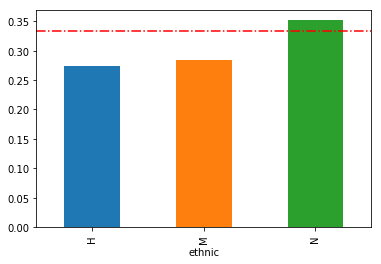

In [42]:
dfs.groupby('ethnic').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

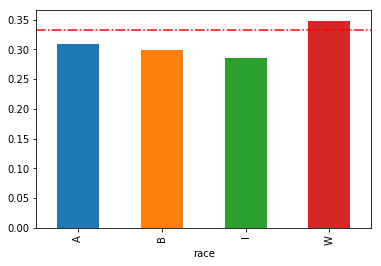

In [43]:
dfs.groupby('race').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

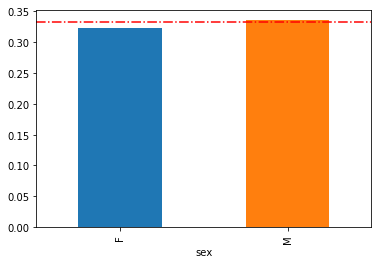

In [44]:
dfs.groupby('sex').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

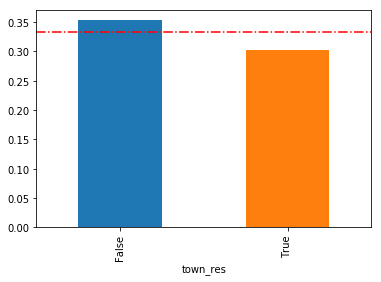

In [45]:
dfs.groupby('town_res').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

In [50]:
dfs['dayofweek'] = dfs.date.dt.dayofweek

In [51]:
dfs['hour'] = dfs.date.dt.hour

In [52]:
dfs['month'] = dfs.date.dt.month

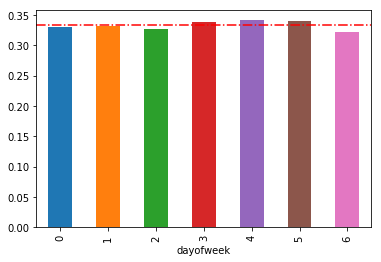

In [56]:
dfs.groupby('dayofweek').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

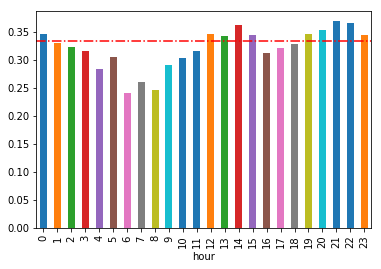

In [57]:
dfs.groupby('hour').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

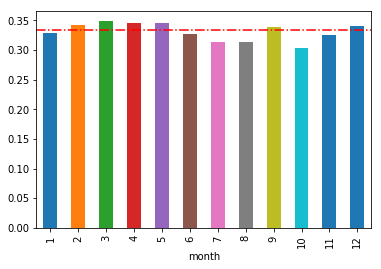

In [58]:
dfs.groupby('month').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');